In [1]:
import os
import pandas as pd
import string
from datetime import datetime
from os import path
import json
import numpy as np

In [2]:
with open(path.expanduser("~") + "/sys_specific.json") as file: 
    params = json.load(file)
_HOME_ = params["home"] + "/PHD"

excel_path = _HOME_ + "/MSFD/Data/Modulo1/"

In [3]:
with open(_HOME_ + "/ISPRA_20152017_Analysis/params.json") as file: 
    params = json.load(file)
best_path = params["best_path"]
best_path_sard = params["best_path_sard"]
ordered_regions = params["ordered_regions"]
seasons = params["seasons"]
sorted_season = params["sorted_season"]
sea_index = params["sea_index"]
ordered_id = params["ordered_id"]
sea_index_array = np.array(list(sea_index.values()))
del params

# import data

In [69]:
raw_data = pd.read_csv(excel_path + "chemical_fis_raw.csv", dtype = str)

In [70]:
raw_data.rename(columns= {"NationalStationID" : "id", "Determinand_Nutrients" : "Nutrient"}, inplace=True)

# check id and date

In [71]:
raw_data["id"] = raw_data["id"].apply(lambda x: x.split(".")[0])
raw_data["id"] = raw_data["id"].apply(lambda x: str.strip(x))
raw_data["id"] = raw_data["id"].apply(lambda x: x.replace("M000200", "MS00200"))

In [72]:
raw_data["Year"] = raw_data["Year"].apply(lambda x: x.split(".")[0])
raw_data["Month"] = raw_data["Month"].apply(lambda x: x.split(".")[0])
raw_data["Day"] = raw_data["Day"].apply(lambda x: x.split(".")[0])

In [73]:
raw_data["Date"] = pd.to_datetime([f"{year}-{month}-{day}" for year, month, day in zip(raw_data["Year"], raw_data["Month"], raw_data["Day"])], format = "%Y-%m-%d").date
raw_data.drop(columns = ["Year", "Month", "Day", "Time"], inplace=True)

In [74]:
raw_data["SampleDepth"] = raw_data["SampleDepth"].astype(float)

# check nutrients

In [75]:
#ox saturation
raw_data.loc[raw_data["Nutrient"].isin(['Temperature (water)', 'Temperature ', "Temperature"]), "Nutrient"] = "T"
raw_data.loc[raw_data["Nutrient"].isin(['Electrical Conductivity', ' Electrical Conductivity', 'Electrical conductivity']), "Nutrient"] = 'E_cond'
raw_data.loc[raw_data["Nutrient"].isin(['Dissolved Oxygen', 'Dissolved oxygen']), "Nutrient"] = 'DO'
raw_data.loc[raw_data["Nutrient"].isin([' ', 'Oxygen Saturation', 'Oxygen saturation']), "Nutrient"] = 'O_sat'

In [76]:
raw_data.loc[raw_data["Nutrient"].isin([' pH', 'pH ']), "Nutrient"] = 'pH'
raw_data.loc[raw_data["Nutrient"].isin(['Chlorophyll a']), "Nutrient"] = 'Chla'
raw_data.loc[raw_data["Nutrient"].isin(['Secchi depth']), "Nutrient"] = 'Secchi_depth'
raw_data.loc[raw_data["Nutrient"].isin(['Nitrate']), "Nutrient"] = 'NO3'
raw_data.loc[raw_data["Nutrient"].isin(['Nitrite']), "Nutrient"] = 'NO2'
raw_data.loc[raw_data["Nutrient"].isin(['Ammonium']), "Nutrient"] = 'NH4'
raw_data.loc[raw_data["Nutrient"].isin(['Total phosphorus', 'Total Phosphorus']), "Nutrient"] = 'TP'
raw_data.loc[raw_data["Nutrient"].isin(['Orthophosphates']), "Nutrient"] = 'PO4'
raw_data.loc[raw_data["Nutrient"].isin(['Total nitrogen', 'Total Nitrogen']), "Nutrient"] = 'TN'
raw_data.loc[raw_data["Nutrient"].isin(['Silicate']), "Nutrient"] = 'SiO4'

In [81]:
condition = (raw_data["id"] == "M1FV6")  & (pd.to_datetime(raw_data["Date"]) == datetime(2015,7,17)) & (raw_data["SampleDepth"].isin([42.0, 42.5])) & (raw_data["Nutrient"] == "E_cond")
raw_data.loc[condition, "Concentration"] = [46.6000, 46.5500]

In [82]:
raw_data["Concentration"] = raw_data["Concentration"].astype(str).apply(lambda x: x.replace(",", ".")).astype(float)

## make wide table

In [14]:
raw_data.loc[(~raw_data["Remarks"].isna()) & (raw_data["Nutrient"] != "Chla"), :].to_csv(_HOME_ + "/ISPRA_20152017_Analysis/Create_dataset/remarks_nut.csv", index=0)

## CHECK with ML data

In [13]:
ml_2016 = pd.read_excel(excel_path + "QC_2016_V28.02.2024.xlsx", dtype = str)
ml_2017 = pd.read_excel(excel_path + "QC_2017_V28.02.2024.xlsx", dtype = str)

In [14]:
ml_df = pd.concat([ml_2016, ml_2017], axis=0)

In [15]:
ml_ids = ml_df["LOCAL_CDI_ID"].unique()
ispra_ids = raw_data["id"].unique()
from_ml_to_ispra = {}
for ml_id in ml_ids:
    matching_ids = [ispra_id for ispra_id in ispra_ids if ispra_id in ml_id]
    from_ml_to_ispra[ml_id] = matching_ids

In [16]:
ml_df["LOCAL_CDI_ID"] = ml_df["LOCAL_CDI_ID"].apply(lambda x: from_ml_to_ispra[x][0])
ml_df["time_ISO8601"] = pd.to_datetime(ml_df["time_ISO8601"]).dt.date
ml_df["ADEPZZ01 [Meters]"] = ml_df["ADEPZZ01 [Meters]"].astype(float)

In [17]:
ml_df.rename(columns = {"time_ISO8601" : "Date", 
                        "ADEPZZ01 [Meters]" : "SampleDepth", 
                        'AMONFID2 [Micromoles per litre]': "NH4",
                        'QV:SEADATANET.2' : "QF_NH4", 
                        'CPHLFLP1 [Micrograms per litre]' : "Chla", 
                        'QV:SEADATANET.3' : "QF_Chla",
                        'DOXYSC01 [Micromoles per litre]' : "DO", 
                        'QV:SEADATANET.4' : "QF_DO",
                        'NTOTZZD2 [Micromoles per litre]' : "TN", 
                        'QV:SEADATANET.5' : "QF_TN",
                        'NTRAAA04 [Micromoles per litre]' : "NO3", 
                        'QV:SEADATANET.6' : "QF_NO3",
                        'NTRIAAD2 [Micromoles per litre]' : "NO2", 
                        'QV:SEADATANET.7' : "QF_NO2",
                        'PHOSAAD2 [Micromoles per litre]' : "PO4", 
                        'QV:SEADATANET.8' : "QF_PO4",
                        'PSALCC01 [Dimensionless]' : "Salinity", 
                        'QV:SEADATANET.9' : "QF_Salinity",
                        'SECCSDNX [Metres]' : "Secchi_depth",
                        'QV:SEADATANET.10' : "QF_Secchi_depth",
                        'SLCAAAD2 [Micromoles per litre]' : "SiO4",
                        'QV:SEADATANET.11' : "QF_SiO4",
                        'TEMPCC01 [Degrees Celsius]' : "T", 
                        'QV:SEADATANET.12' : "QF_T",
                        'TPHSZZXX [Micromoles per litre]' : "TP", 
                        'QV:SEADATANET.13' : "QF_TP",
                        "LOCAL_CDI_ID" : "id"
                        }, 
                        inplace=True)

In [18]:
ml_df = ml_df[['id', 'Bot. Depth [m]', 'Date', 'SampleDepth', 'NH4', 'QF_NH4', 'Chla', 'QF_Chla', 'DO', 'QF_DO', 'TN', 'QF_TN', 'NO3', 'QF_NO3', 'NO2', 'QF_NO2', 'PO4', 'QF_PO4', 'Salinity', 'QF_Salinity', 'Secchi_depth', 'QF_Secchi_depth', 'SiO4', 'QF_SiO4', 'T', 'QF_T', 'TP', 'QF_TP']]

In [95]:
nutrients = ["NH4", "Chla", "DO", "TN", "NO3", "NO2", "PO4", "Salinity", "Secchi_depth", "SiO4", "T", "TP"]
for nutrients in nutrients:
    ml_df[nutrients] = ml_df[nutrients].astype(float)

In [90]:
raw_data_wide = pd.pivot_table(raw_data, index = ["id", "Date", "SampleDepth"], columns = "Nutrient", values = "Concentration", aggfunc="mean")#.reset_index()

In [84]:
import matplotlib.pyplot as plt

In [97]:
def compare_histograms(
    dfs,  
    variables : list[str], 
    sup_title : str=None, 
    titles : list[str]=None,
    legend_labels : list[str]=None,
    x_labels : list[str]=None,
    y_labels : list[str]="Relative frequency",
    n_bins : int = 50,
    **kwargs
): 
    if "figsize" in kwargs: 
        figsize_dims = kwargs["figsize"]
    else: 
        figsize_dims = (8,8) if len(variables) == 1 else (8,13)
        
    if len(variables) == 1: 
        fig, axs = plt.subplots(1,1, figsize=figsize_dims)
    else : 
        n_rows = len(variables) // 2 
        fig, axs = plt.subplots(n_rows,2, figsize=figsize_dims)
        axs = axs.flat
    
    if sup_title: 
        plt.suptitle(sup_title)
        
    for ax, var, title, x_label, y_label in zip(fig.axes, variables, titles, x_labels, y_labels):
        right_edge = -np.inf
        left_edge = np.inf
        datas = [df[var].dropna().to_numpy() for df in dfs]
        for data in datas:
            right_edge = data.max() if right_edge < data.max() else right_edge
            left_edge = data.min() if left_edge > data.min() else left_edge
            
        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        
        for data, label in zip(datas, legend_labels): 
            ax.hist(data, 
                    bins=np.linspace(left_edge,right_edge, n_bins, endpoint=True), 
                    alpha=0.5, 
                    weights=np.ones_like(data) / len(data),
                    label=label)
            ax.legend()
        
        fig.tight_layout()


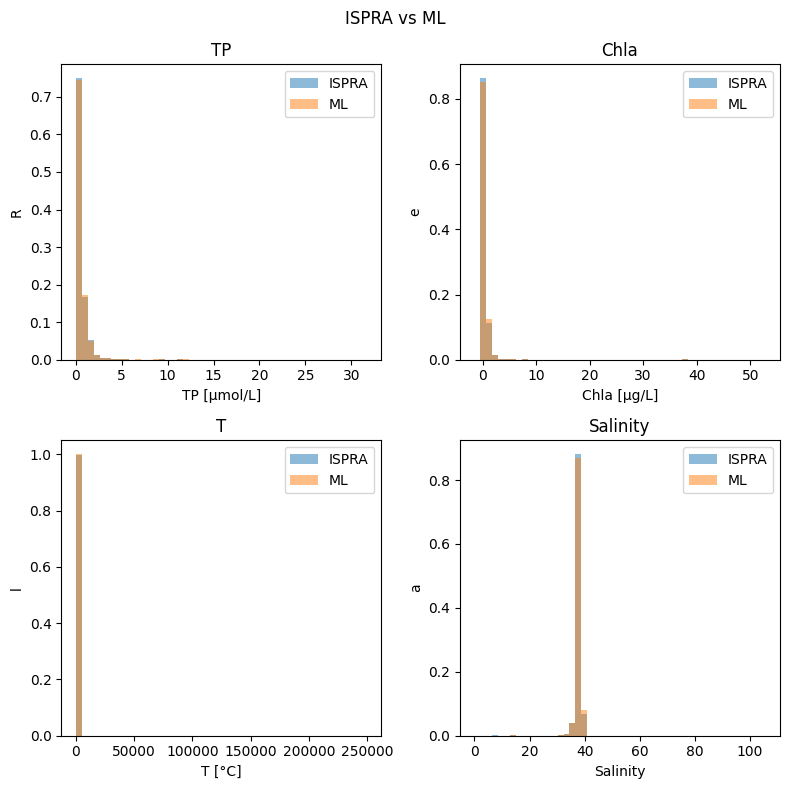

In [98]:
compare_histograms([raw_data_wide, ml_df], variables= ["TP", "Chla", "T", "Salinity"], titles = ["TP", "Chla", "T", "Salinity"], legend_labels = ["ISPRA", "ML"], x_labels = ["TP [µmol/L]", "Chla [µg/L]", "T [°C]", "Salinity"], sup_title = "ISPRA vs ML", figsize=(8,8))